In [46]:
#step 1: import the libirary
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log


In [51]:
#

# Import File

In [45]:
# Step 2: Import file
data = pd.read_excel('aggregated_dataset(in).xlsx')
data_population = pd.read_excel('city_code_population_demographics.xlsx')
data["Formatted_Date"] = pd.to_datetime(data["month_year"]).dt.strftime("%d-%m")

In [48]:
# combine population with each city
aggregated_data_final = data.merge(right=data_population[['city_code','province_population']], on='city_code', how='left')
aggregated_data_final = pd.DataFrame(aggregated_data_final)
aggregated_data_final

,city_code,month_year,event_congress,event_meeting,F2F_visit,remote_visit,Mass Mail Count,Rep Triggered Email Count,agg_prescriptions,unit_price,Formatted_Date,province_population
0,City01,2024-01-23,0,0,26,0,0,0,20.0,6815.0,23-01,2270298.0
1,City01,2024-02-23,0,0,156,0,0,0,19.0,6815.0,23-02,2270298.0
2,City01,2024-03-23,0,5,255,3,0,0,21.0,6815.0,23-03,2270298.0
3,City01,2024-04-23,2,0,158,0,33,0,22.0,6815.0,23-04,2270298.0
4,City01,2024-05-23,3,0,328,2,4,0,29.0,6815.0,23-05,2270298.0
...,...,...,...,...,...,...,...,...,...,...,...,...
775,City82,2024-12-23,0,0,0,0,0,2,7.0,8893.0,23-12,591492.0
776,City82,2024-02-24,0,1,0,0,0,0,6.0,11116.0,24-02,591492.0
777,City82,2024-03-24,0,0,0,0,0,9,22.0,10000.0,24-03,591492.0
778,City82,2024-04-24,0,1,0,0,1,3,NaN,10000.0,24-04,591492.0


In [50]:
##check if there is no population value 
null_df = aggregated_data_final[aggregated_data_final["province_population"].isnull()]
null_df['city_code'].value_counts() 



City07    19
City12    18
Name: city_code, dtype: int64

- There are two cities do not have population, so we either delete them or make up missing value

## New feature 
- Percentage of prescriptions filled by populations 
- and Prescription_Growth

In [56]:

# New feature - percentage of prescriptions filled by populations

aggregated_data_final['pct_prescription_1K'] = aggregated_data_final['agg_prescriptions'] / aggregated_data_final['province_population']*10000

# Define a function to handle zero previous prescriptions
# def calculate_growth(current, previous):
#     if previous == 0:
#         return 0  # Assign None, "New Market", or any custom value
#     else:
#         return ((current - previous) / previous) * 100

# Add a column for previous month's prescriptions
# aggregated_data_final['Previous_Prescriptions'] = aggregated_data_final.groupby('city_code')['agg_prescriptions'].shift()

# # Apply the growth calculation function
# aggregated_data_final['Prescription_Growth'] = aggregated_data_final.apply(lambda row: calculate_growth(row['agg_prescriptions'], row['Previous_Prescriptions']), axis=1)
# aggregated_data_final['Prescription_Growth'] = aggregated_data_final['Prescription_Growth'].fillna(0)



def calculate_growth(current, previous):
    if previous == 0:  # Handle division by zero
        return (current - previous) / current * 100 if current != 0 else 0
    else:
        return (current - previous) / previous * 100

# Apply growth calculation
aggregated_data_final['Prescription_Growth']  = aggregated_data_final['agg_prescriptions'].diff().fillna(0).apply(
    lambda x: calculate_growth(aggregated_data_final['agg_prescriptions'].iloc[aggregated_data_final.index[aggregated_data_final['agg_prescriptions'].diff() == x].tolist()[0]], aggregated_data_final['agg_prescriptions'].iloc[aggregated_data_final.index[aggregated_data_final['agg_prescriptions'].diff() == x].tolist()[0]-1])
)
 

In [61]:
aggregated_data_final[aggregated_data_final["city_code"]=="City06"]

,city_code,month_year,event_congress,event_meeting,F2F_visit,remote_visit,Mass Mail Count,Rep Triggered Email Count,agg_prescriptions,unit_price,Formatted_Date,province_population,pct_prescription_1K,Previous_Prescriptions,Prescription_Growth
47,City06,2024-02-23,0,0,3,0,0,0,0.0,6815.0,23-02,339529.0,0.000000,NaN,0.000000
48,City06,2024-03-23,0,0,4,0,0,0,8.0,6815.0,23-03,339529.0,0.235621,0.0,100.000000
49,City06,2024-04-23,0,0,2,0,1,0,4.0,6815.0,23-04,339529.0,0.117810,8.0,-50.000000
50,City06,2024-05-23,0,0,2,0,0,0,0.0,6815.0,23-05,339529.0,0.000000,4.0,-50.000000
51,City06,2024-06-23,0,0,1,0,0,0,4.0,6815.0,23-06,339529.0,0.117810,0.0,12.500000
52,City06,2024-07-23,0,0,2,0,1,0,5.0,6815.0,23-07,339529.0,0.147263,4.0,4.761905
53,City06,2024-08-23,0,0,1,0,0,0,0.0,8893.0,23-08,339529.0,0.000000,5.0,-17.241379
54,City06,2024-09-23,0,0,1,0,0,0,0.0,8893.0,23-09,339529.0,0.000000,0.0,0.000000
55,City06,2024-04-24,0,0,0,0,1,0,NaN,10000.0,24-04,339529.0,NaN,0.0,0.000000


# Group by city to calculate average sales and Growth per city

In [63]:

# Group by city to calculate average sales
average_sales_df = aggregated_data_final.groupby('city_code').agg({
    'pct_prescription_1K': 'mean',  # Calculate average sales
    'Prescription_Growth': 'mean',  # Calculate average sales
    'province_population': 'first'  # Population remains constant for each city
}).reset_index()
 
 

In [64]:
average_sales_df

,city_code,pct_prescription_1K,Prescription_Growth,province_population
0,City01,0.135371,5.574680,2270298.0
1,City02,0.022728,13.786028,604978.0
2,City03,0.039928,0.554684,751344.0
3,City04,0.007113,0.877193,511238.0
4,City06,0.077313,0.002281,339529.0
...,...,...,...,...
62,City78,0.150309,14.714156,377001.0
63,City79,0.056905,21.194630,1127612.0
64,City80,0.054684,5.554596,304780.0
65,City81,0.047540,0.000000,420699.0


In [10]:
# # Calculate correlation
# correlation = aggregated_data_final[['population', 'agg_prescriptions']].corr()
# print("Correlation Matrix:\n", correlation)

# Segmentation:
- High Potential: Cities with low prescriptions per capita but large populations.</b>
- High Performing: Cities with relatively higher prescriptions per capita compared to others.
- Emerging Markets: Cities with increasing trends in prescriptions.
- Needs Attention: low population and no potential

In [103]:
# Example Segmentation
def segment_city(row):
    if row['pct_prescription_1K'] >= 0.15:
        return 'High Performing'
    elif row['pct_prescription_1K'] >= 0.08 and row['Prescription_Growth'] > 0:
        return 'Emerging Market'
    elif row['pct_prescription_1K'] < 0.1 and row['province_population'] > 1005000:
        return 'High Potential' 
    
    else:
        return 'Needs Attention'

average_sales_df['City_Segment'] = average_sales_df.apply(segment_city, axis=1)

  

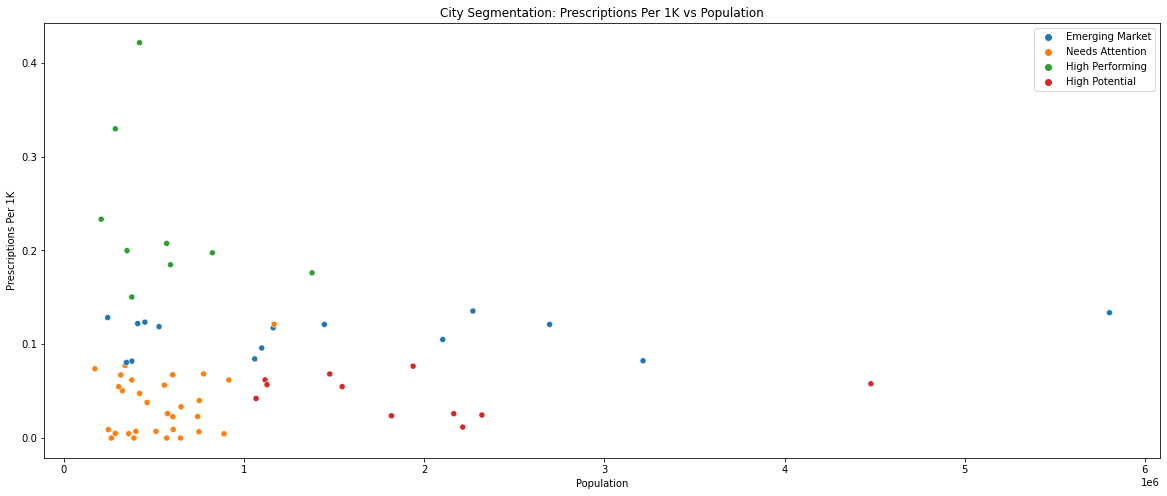

In [104]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=average_sales_df, x='province_population', y='pct_prescription_1K', hue='City_Segment')
plt.title('City Segmentation: Prescriptions Per 1K vs Population')
plt.xlabel('Population')
plt.ylabel('Prescriptions Per 1K')
plt.legend()
plt.show()


In [109]:
cluster_data

,city_code,month_year,event_congress,event_meeting,F2F_visit,remote_visit,Mass Mail Count,Rep Triggered Email Count,agg_prescriptions,unit_price,Formatted_Date,province_population,pct_prescription_1K,Previous_Prescriptions,Prescription_Growth,City_Segment
253,City28,2024-01-23,0,0,43,0,0,0,1.0,6815.0,23-01,1818133.0,0.005500,NaN,0.000000,High Potential
254,City28,2024-02-23,0,0,85,0,0,0,3.0,6815.0,23-02,1818133.0,0.016500,1.0,10.526316,High Potential
255,City28,2024-03-23,0,0,142,0,0,0,4.0,6815.0,23-03,1818133.0,0.022001,3.0,4.761905,High Potential
256,City28,2024-04-23,1,0,118,0,10,0,2.0,6815.0,23-04,1818133.0,0.011000,4.0,-5.263158,High Potential
257,City28,2024-05-23,0,0,196,0,1,0,5.0,6815.0,23-05,1818133.0,0.027501,2.0,100.000000,High Potential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,City79,2024-08-23,0,0,22,2,0,0,3.0,8893.0,23-08,1127612.0,0.026605,11.0,-16.326531,High Potential
748,City79,2024-09-23,0,0,52,7,0,9,2.0,8893.0,23-09,1127612.0,0.017737,3.0,-5.000000,High Potential
749,City79,2024-10-23,0,0,0,0,0,1,5.0,8893.0,23-10,1127612.0,0.044341,2.0,100.000000,High Potential
750,City79,2024-11-23,0,0,0,0,0,21,13.0,8893.0,23-11,1127612.0,0.115288,5.0,100.000000,High Potential


In [114]:
 

# 合并数据
merged_df = pd.merge(aggregated_data_final, average_sales_df[['city_code', 'City_Segment']],
                    on='city_code', how='left')
merged_df['Year'] = merged_df['Formatted_Date'].str[:2]  # First 4 characters are the year
merged_df['Month'] = merged_df['Formatted_Date'].str[3:]  # Characters after the hyphen are the month
 
merged_df['Month']= merged_df['Month'].fillna(0).astype(int)
merged_df['Year']= merged_df['Year'].fillna(0).astype(int)

# Lagging the target variable (for time series modeling)
merged_df['agg_prescriptions_lagged'] = merged_df['agg_prescriptions'].shift(1)  # Lagged version of Y by 1 day



# 2. 为每个聚类建立预测模型
for cluster in average_sales_df['City_Segment'].unique():
    print(f"\n分析聚类 {cluster}")

    # 获取该聚类的数据
    cluster_data = merged_df[merged_df['City_Segment'] == cluster].copy()
    

    # 准备特征
    features = ['event_congress', 'event_meeting', 'F2F_visit',
               'remote_visit', 'Mass Mail Count', 'Rep Triggered Email Count',
                'agg_prescriptions_lagged','Year','Month']

    # 移除缺失值
    cluster_data = cluster_data.dropna(subset=features + ['agg_prescriptions'])

    X = cluster_data[features]
    y = cluster_data['agg_prescriptions']

    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 模型1: 基础OLS
    print("\n模型1: 基础OLS")
    model1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    print(model1.summary().tables[1])

    # 模型2: 带交互项的OLS
    print("\n模型2: 带交互项的OLS")
    X_interact = X_train.copy()
    X_interact['F2F_remote_interact'] = X_train['F2F_visit'] * X_train['remote_visit']
    model2 = sm.OLS(y_train, sm.add_constant(X_interact)).fit()
    print(model2.summary().tables[1])

    # 模型3: 带二次项的OLS
    print("\n模型3: 带二次项的OLS")
    X_squared = X_train.copy()
    X_squared['F2F_visit_squared'] = X_train['F2F_visit'] ** 2
    model3 = sm.OLS(y_train, sm.add_constant(X_squared)).fit()
    print(model3.summary().tables[1])

    # 模型4: GLM with Poisson family
    print("\n模型4: GLM with Poisson")
    model4 = sm.GLM(y_train, sm.add_constant(X_train),
                    family=sm.families.Poisson()).fit()
    print(model4.summary().tables[1])



分析聚类 Emerging Market

模型1: 基础OLS
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        83.0617     70.554      1.177      0.241     -56.595     222.719
event_congress                3.2900      1.132      2.907      0.004       1.050       5.530
event_meeting                 0.9289      0.400      2.321      0.022       0.137       1.721
F2F_visit                    -0.0180      0.012     -1.448      0.150      -0.043       0.007
remote_visit                  0.7688      0.310      2.482      0.014       0.156       1.382
Mass Mail Count               0.0038      0.232      0.017      0.987      -0.456       0.463
Rep Triggered Email Count     0.2087      0.084      2.498      0.014       0.043       0.374
agg_prescriptions_lagged      0.5992      0.054     11.089      0.000       0.492       0.706
Year                      

C:\Users\yu301\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in scalar subtract
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -53.2186     89.067     -0.598      0.552    -231.205     124.767
event_congress                0.3794      2.094      0.181      0.857      -3.806       4.565
event_meeting                 0.0416      0.578      0.072      0.943      -1.113       1.196
F2F_visit                     0.0602      0.044      1.382      0.172      -0.027       0.147
remote_visit                 -1.0754      1.321     -0.814      0.419      -3.715       1.564
Mass Mail Count               0.9131      0.625      1.462      0.149      -0.335       2.161
Rep Triggered Email Count     0.1257      0.111      1.129      0.263      -0.097       0.348
agg_prescriptions_lagged      0.3380      0.141      2.398      0.019       0.056       0.620
Year                          2.5361      3.804      0.667  

C:\Users\yu301\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in scalar subtract
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


In [115]:
  
# 合并数据
merged_df = pd.merge(aggregated_data_final, average_sales_df[['city_code', 'City_Segment']],
                    on='city_code', how='left')
merged_df['Year'] = merged_df['Formatted_Date'].str[:2]  # First 4 characters are the year
merged_df['Month'] = merged_df['Formatted_Date'].str[3:]  # Characters after the hyphen are the month
 
merged_df['Month']= merged_df['Month'].fillna(0).astype(int)
merged_df['Year']= merged_df['Year'].fillna(0).astype(int)

# Lagging the target variable (for time series modeling)
merged_df['agg_prescriptions_lagged'] = merged_df['agg_prescriptions'].shift(1)  # Lagged version of Y by 1 day


# 创建一个DataFrame来存储所有R²值
r2_results = pd.DataFrame(columns=['Cluster', 'Model', 'Train_R2', 'Test_R2'])

# 2. 为每个聚类建立预测模型
for cluster in average_sales_df['City_Segment'].unique():
    if pd.isna(cluster):
        continue

    print(f"\n分析聚类 {cluster}")

    # 获取该聚类的数据
    cluster_data = merged_df[merged_df['City_Segment'] == cluster].copy()

    # 准备特征
    features = ['event_congress', 'event_meeting', 'F2F_visit',
               'remote_visit', 'Mass Mail Count', 'Rep Triggered Email Count'  ,
                'agg_prescriptions_lagged','Year','Month']

    # 移除缺失值
    cluster_data = cluster_data.dropna(subset=features + ['agg_prescriptions'])

    X = cluster_data[features]
    y = cluster_data['agg_prescriptions']

    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 模型1: 基础OLS
    model1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    train_pred1 = model1.predict(sm.add_constant(X_train))
    test_pred1 = model1.predict(sm.add_constant(X_test))
    r2_results = pd.concat([r2_results, pd.DataFrame({
        'Cluster': [cluster],
        'Model': ['Basic OLS'],
        'Train_R2': [r2_score(y_train, train_pred1)],
        'Test_R2': [r2_score(y_test, test_pred1)]
    })])

    # 模型2: 带交互项的OLS
    X_interact_train = X_train.copy()
    X_interact_test = X_test.copy()
    X_interact_train['F2F_remote_interact'] = X_train['F2F_visit'] * X_train['remote_visit']
    X_interact_test['F2F_remote_interact'] = X_test['F2F_visit'] * X_test['remote_visit']
    model2 = sm.OLS(y_train, sm.add_constant(X_interact_train)).fit()
    train_pred2 = model2.predict(sm.add_constant(X_interact_train))
    test_pred2 = model2.predict(sm.add_constant(X_interact_test))
    r2_results = pd.concat([r2_results, pd.DataFrame({
        'Cluster': [cluster],
        'Model': ['OLS with Interaction'],
        'Train_R2': [r2_score(y_train, train_pred2)],
        'Test_R2': [r2_score(y_test, test_pred2)]
    })])

    # 模型3: 带二次项的OLS
    X_squared_train = X_train.copy()
    X_squared_test = X_test.copy()
    X_squared_train['F2F_visit_squared'] = X_train['F2F_visit'] ** 2
    X_squared_test['F2F_visit_squared'] = X_test['F2F_visit'] ** 2
    model3 = sm.OLS(y_train, sm.add_constant(X_squared_train)).fit()
    train_pred3 = model3.predict(sm.add_constant(X_squared_train))
    test_pred3 = model3.predict(sm.add_constant(X_squared_test))
    r2_results = pd.concat([r2_results, pd.DataFrame({
        'Cluster': [cluster],
        'Model': ['OLS with Squared Terms'],
        'Train_R2': [r2_score(y_train, train_pred3)],
        'Test_R2': [r2_score(y_test, test_pred3)]
    })])

    # 模型4: GLM with Poisson family
    try:
        model4 = sm.GLM(y_train, sm.add_constant(X_train),
                        family=sm.families.Poisson()).fit()
        train_pred4 = model4.predict(sm.add_constant(X_train))
        test_pred4 = model4.predict(sm.add_constant(X_test))
        r2_results = pd.concat([r2_results, pd.DataFrame({
            'Cluster': [cluster],
            'Model': ['Poisson GLM'],
            'Train_R2': [r2_score(y_train, train_pred4)],
            'Test_R2': [r2_score(y_test, test_pred4)]
        })])
    except:
        print(f"Cluster {cluster}: Poisson GLM failed to converge")

# 重置索引并格式化结果
r2_results = r2_results.reset_index(drop=True)
r2_results[['Train_R2', 'Test_R2']] = r2_results[['Train_R2', 'Test_R2']].round(3)

# 按聚类分组显示结果
for cluster in r2_results['Cluster'].unique():
    print(f"\n聚类 {cluster} 的R²值:")
    print(r2_results[r2_results['Cluster'] == cluster].to_string(index=False))


分析聚类 Emerging Market

分析聚类 Needs Attention

分析聚类 High Performing

分析聚类 High Potential

聚类 Emerging Market 的R²值:
        Cluster                  Model  Train_R2  Test_R2
Emerging Market              Basic OLS     0.804    0.554
Emerging Market   OLS with Interaction     0.806    0.569
Emerging Market OLS with Squared Terms     0.841    0.292
Emerging Market            Poisson GLM     0.681    0.534

聚类 Needs Attention 的R²值:
        Cluster                  Model  Train_R2  Test_R2
Needs Attention              Basic OLS     0.924    0.532
Needs Attention   OLS with Interaction     0.929    0.536
Needs Attention OLS with Squared Terms     0.926    0.480
Needs Attention            Poisson GLM     0.808  -15.173

聚类 High Performing 的R²值:
        Cluster                  Model  Train_R2  Test_R2
High Performing              Basic OLS     0.292    0.543
High Performing   OLS with Interaction     0.299    0.557
High Performing OLS with Squared Terms     0.426    0.289
High Performing        

# Marketing Analysis for Emerging Markets

In [98]:
import matplotlib.pyplot as plt
# Merge the two datasets
merged_df = pd.merge(aggregated_data_final, average_sales_df[average_sales_df['City_Segment']=="Emerging Market"], on='city_code', how='inner')
# Keep only selected columns
df_emerging_markets = merged_df[['city_code', 'Formatted_Date',
                         'event_congress','event_meeting','F2F_visit','remote_visit','Mass Mail Count','Rep Triggered Email Count',
                         'agg_prescriptions']]

df_emerging_markets
# df_emerging_markets['Rep Triggered Email Count_Efficiency'] = df_emerging_markets['agg_prescriptions'] / df_emerging_markets['Rep Triggered Email Count']

,city_code,Formatted_Date,event_congress,event_meeting,F2F_visit,remote_visit,Mass Mail Count,Rep Triggered Email Count,agg_prescriptions
0,City01,23-01,0,0,26,0,0,0,20.0
1,City01,23-02,0,0,156,0,0,0,19.0
2,City01,23-03,0,5,255,3,0,0,21.0
3,City01,23-04,2,0,158,0,33,0,22.0
4,City01,23-05,3,0,328,2,4,0,29.0
...,...,...,...,...,...,...,...,...,...
199,City70,23-02,0,0,5,0,0,0,3.0
200,City70,23-03,0,0,3,0,0,0,0.0
201,City70,23-04,0,0,5,0,1,0,2.0
202,City70,23-05,0,0,4,0,1,0,6.0


<!-- # How strongly are channels correlated with prescription?
--ignore cities and month-year -->

<!-- 1 F2F and event_congress has the highest correlation with sales (0.59,0.43), suggesting it is likely the most impactful channel. <br />
2 F2F and event_congress related to each other.--0.51 <br />
2 EVENT meeting have strong correlation with Email, maybe becuase the email will be sent for reminder or invitation -->

# Fit into model to predict  
- add Month and Year variable instead of year-month
- add agg_prescriptions_lagged
- build interaction effect 

In [99]:
data_model

,city_code,Formatted_Date,event_congress,event_meeting,F2F_visit,remote_visit,Mass Mail Count,Rep Triggered Email Count,agg_prescriptions,Year,Month,agg_prescriptions_lagged
1,City01,23-02,0,0,156,0,0,0,19.0,23,2,20.0
2,City01,23-03,0,5,255,3,0,0,21.0,23,3,19.0
3,City01,23-04,2,0,158,0,33,0,22.0,23,4,21.0
4,City01,23-05,3,0,328,2,4,0,29.0,23,5,22.0
5,City01,23-06,0,0,210,0,0,0,24.0,23,6,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
196,City68,24-03,0,0,0,0,0,18,6.0,24,3,5.0
199,City70,23-02,0,0,5,0,0,0,3.0,23,2,3.0
200,City70,23-03,0,0,3,0,0,0,0.0,23,3,3.0
201,City70,23-04,0,0,5,0,1,0,2.0,23,4,0.0


In [100]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
data_model=df_emerging_markets


# Convert to datetime format
data_model['Year'] = data_model['Formatted_Date'].str[:2]  # First 4 characters are the year
data_model['Month'] = data_model['Formatted_Date'].str[3:]  # Characters after the hyphen are the month
 
data_model['Month']= data_model['Month'].fillna(0).astype(int)
data_model['Year']= data_model['Year'].fillna(0).astype(int)

# Lagging the target variable (for time series modeling)
data_model['agg_prescriptions_lagged'] = data_model['agg_prescriptions'].shift(1)  # Lagged version of Y by 1 day

 
# Drop rows with NaN values after lagging (to avoid issues with missing values)
data_model.dropna(inplace=True)
data_model.replace([np.inf, -np.inf], np.nan, inplace=True)
data_model.fillna(0, inplace=True)

# # Define the independent variables (including the time-related features)
X = data_model[data_model.columns.difference(['agg_prescriptions','month_year','Formatted_Date',"city_code"])]
Y = data_model['agg_prescriptions']  # Dependent variable


C:\Users\yu301\AppData\Local\Temp\ipykernel_14600\3191548450.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['Year'] = data_model['Formatted_Date'].str[:2]  # First 4 characters are the year
C:\Users\yu301\AppData\Local\Temp\ipykernel_14600\3191548450.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['Month'] = data_model['Formatted_Date'].str[3:]  # Characters after the hyphen are the month
C:\Users\yu301\AppData\Local\Temp\ipykernel_14600\3191548450.py:11: SettingWithCopyWarnin

In [101]:
# Interaction Terms
import itertools

# Generate all pairwise combinations of independent variables
combinations = list(itertools.combinations(X.columns, 2))

# Create interaction terms
for var1, var2 in combinations:
    interaction_term = f"{var1}x{var2}"  # Column name for interaction
    X[interaction_term] = X[var1]*X[var2]
    
     
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

 
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

C:\Users\yu301\AppData\Local\Temp\ipykernel_14600\1805636264.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[interaction_term] = X[var1]*X[var2]


In [102]:
# Train the model

OLS_model = sm.OLS(y_train, X_train_const).fit()
print(OLS_model.summary())

y_pred = OLS_model.predict(X_test_const)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test R-squared: {r2}')

# Calculate Mean Absolute Percentage Deviation (MAPD)
mapd = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Test MAPD: {mapd}%')

# Calculate AIC and BIC
aic = OLS_model.aic
bic = OLS_model.bic
print(f'AIC: {aic}')
print(f'BIC: {bic}')

# Interpretation of coefficients
coefficients = OLS_model.params
print('Coefficients:')
print(coefficients)

                            OLS Regression Results                            
Dep. Variable:      agg_prescriptions   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     19.48
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           3.25e-30
Time:                        14:51:08   Log-Likelihood:                -425.97
No. Observations:                 132   AIC:                             933.9
Df Residuals:                      91   BIC:                             1052.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

 - R^2 is 0.883 which means 
 -F2F_visitxRep Triggered Email Count   
Rep Triggered Email Count  
F2F_visitxMonth
F2F_visitxremote_visit 
MonthxRep Triggered Email Count
Rep Triggered Email CountxYear
Rep Triggered Email Countxevent_meeting
event_congressxremote_visit
  

In [19]:
data_model

,city_code,Formatted_Date,event_congress,event_meeting,F2F_visit,remote_visit,Mass Mail Count,Rep Triggered Email Count,agg_prescriptions,Year,Month,agg_prescriptions_lagged
1,City01,23-02,0,0,156,0,0,0,19.0,23,2,20.0
2,City01,23-03,0,5,255,3,0,0,21.0,23,3,19.0
3,City01,23-04,2,0,158,0,33,0,22.0,23,4,21.0
4,City01,23-05,3,0,328,2,4,0,29.0,23,5,22.0
5,City01,23-06,0,0,210,0,0,0,24.0,23,6,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
422,City82,23-09,0,0,4,2,0,2,4.0,23,9,10.0
423,City82,23-11,0,0,0,0,0,2,15.0,23,11,4.0
424,City82,23-12,0,0,0,0,0,2,7.0,23,12,15.0
425,City82,24-02,0,1,0,0,0,0,6.0,24,2,7.0


# When it the best time to reach out cx

In [43]:
city_monthly_data

,city_code,Month,event_congress,event_meeting,F2F_visit,remote_visit,Mass Mail Count,Rep Triggered Email Count,agg_prescriptions,Year,agg_prescriptions_lagged
0,City01,1,0,0,0,0,0,12,36.0,24,38.0
1,City01,2,1,0,156,0,0,0,68.0,47,56.0
2,City01,3,0,5,255,3,0,10,48.0,47,68.0
3,City01,4,2,0,158,0,33,0,22.0,23,21.0
4,City01,5,3,0,328,2,4,0,29.0,23,22.0
...,...,...,...,...,...,...,...,...,...,...,...
307,City82,7,0,0,2,0,0,0,7.0,23,24.0
308,City82,8,0,0,2,0,0,0,10.0,23,7.0
309,City82,9,0,0,4,2,0,2,4.0,23,10.0
310,City82,11,0,0,0,0,0,2,15.0,23,4.0


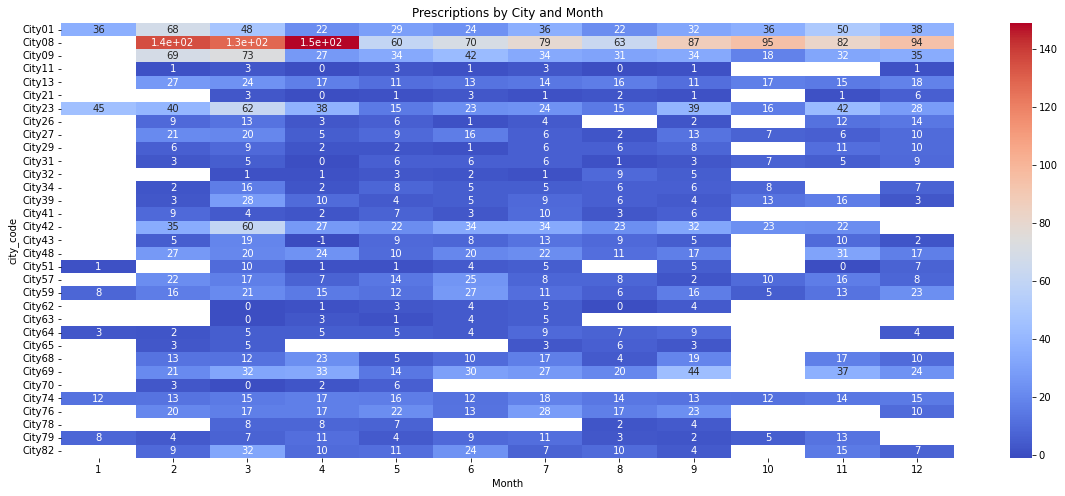

In [21]:
# Aggregate by city and month
city_monthly_data = data_model.groupby(['city_code', 'Month']).sum().reset_index()
city_monthly_data

import seaborn as sns
plt.rcParams["figure.figsize"] = [20, 8]  # Width: 12, Height: 8
# Pivot table for heatmap
pivot_table = city_monthly_data.pivot('city_code', 'Month', 'agg_prescriptions')
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Prescriptions by City and Month')
plt.show()


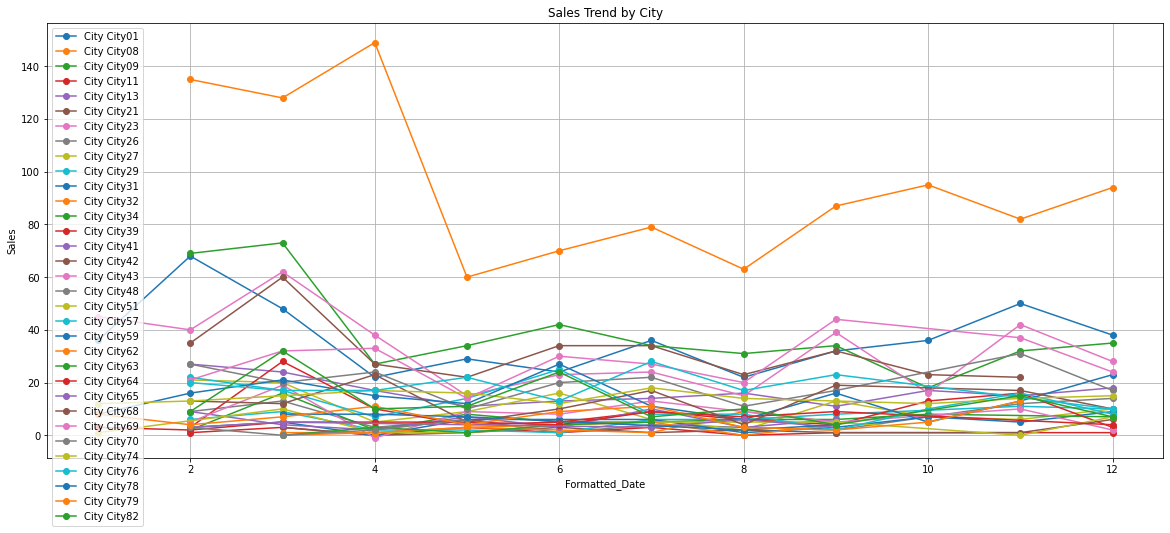

In [44]:
for city in city_monthly_data["city_code"].unique():
    city_data = city_monthly_data[city_monthly_data["city_code"] == city] 
    plt.plot(city_data["Month"], city_data["agg_prescriptions"], marker='o', label=f"City {city}")
    
    
plt.rcParams["figure.figsize"] = [20, 8]  # Width: 12, Height: 8
 
plt.xlabel("Formatted_Date")
plt.ylabel("Sales")
plt.title("Sales Trend by City")
plt.legend()
plt.grid()
plt.show()

# optimal allotment

In [300]:
elasticities = {}
for var in X_train.columns:
    elasticity = coefficients[var] * X_train[var].mean() / y_train.mean()
    elasticities[var] = elasticity
print('Elasticities:')
print(elasticities)

Elasticities:
{'F2F_visit': 0.00016297021861763657, 'Mass Mail Count': -0.00048358086948176654, 'Month': 14.484135137676086, 'Rep Triggered Email Count': 14.812389648601371, 'Year': 5.092737566741574, 'agg_prescriptions_lagged': -0.6388344387800268, 'event_congress': -1.5016001418043496, 'event_meeting': -1.2205937341269852, 'remote_visit': 4.282998751070727e-06, 'F2F_visitxMass Mail Count': 0.06553376519870908, 'F2F_visitxMonth': 0.1579987261313045, 'F2F_visitxRep Triggered Email Count': -0.006084948238367495, 'F2F_visitxYear': 0.08621126075469006, 'F2F_visitxagg_prescriptions_lagged': -0.06654028606112071, 'F2F_visitxevent_congress': -0.04378732888330663, 'F2F_visitxevent_meeting': 0.0340925489152097, 'F2F_visitxremote_visit': -0.1255998066377888, 'Mass Mail CountxMonth': 0.27724970025549467, 'Mass Mail CountxRep Triggered Email Count': -0.0, 'Mass Mail CountxYear': -0.25581428025957825, 'Mass Mail Countxagg_prescriptions_lagged': -0.10793310972319813, 'Mass Mail Countxevent_congress

In [ ]:
Are certain channels more effective in specific cities?

Which Channel Has the Biggest Effect?

Look at the largest coefficients for main effects and their interactions.
In this case, Channel_A consistently has the largest positive effect across city groups.
How Do Channels Differ by Group?

Use interaction terms to assess group-specific effects.
Here, Channel_B is less effective in Group 2, while Channel_A becomes slightly more impactful.
Significance Testing:

Focus on coefficients with p-values < 0.05.
Ignore interaction terms that are not statistically significant.